In [ ]:
!pip uninstall tf-keras
!pip install tensorflow==2.16.1

In [ ]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.8.0 Tensorflow Current Version: 2.16.1


In [ ]:
import os, random, datetime
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.nasnet import NASNetMobile, preprocess_input as preprocess_input_nasnet

In [ ]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


def print_predicted_classes(predicted_classes):
    for full_path, (label, probability) in predicted_classes.items():
        filename = os.path.basename(full_path)
        print(f"{filename}: {label} ({probability:.2f}%)")

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

In [ ]:
import zipfile
import os

# 1. Yol: Zip dosyasının yolu
zip_path = "/content/drive/MyDrive/Garbage classification.zip adlı dosyanın kopyası adlı dosyanın kopyası"

# 2. Açılacağı klasör
extract_path = "/content/garbage_data"

# 3. Klasörü oluştur (varsa sorun olmaz)
os.makedirs(extract_path, exist_ok=True)

# 4. Zip'i aç
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Zip dosyası başarıyla açıldı!")



✅ Zip dosyası başarıyla açıldı!


Task 1

In [ ]:
import pandas as pd

data = []

for root, dirs, files in os.walk("/content/garbage_data"):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            label = os.path.basename(root)  # klasör adı
            full_path = os.path.join(root, file)
            data.append((full_path, label))

df = pd.DataFrame(data, columns=["image_path", "label"])
print(df.head())
df.to_csv("image_paths_labels.csv", index=False)



                                          image_path  label
0  /content/garbage_data/Garbage classification/t...  trash
1  /content/garbage_data/Garbage classification/t...  trash
2  /content/garbage_data/Garbage classification/t...  trash
3  /content/garbage_data/Garbage classification/t...  trash
4  /content/garbage_data/Garbage classification/t...  trash


Task 2

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df = pd.read_csv("image_paths_labels.csv")
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


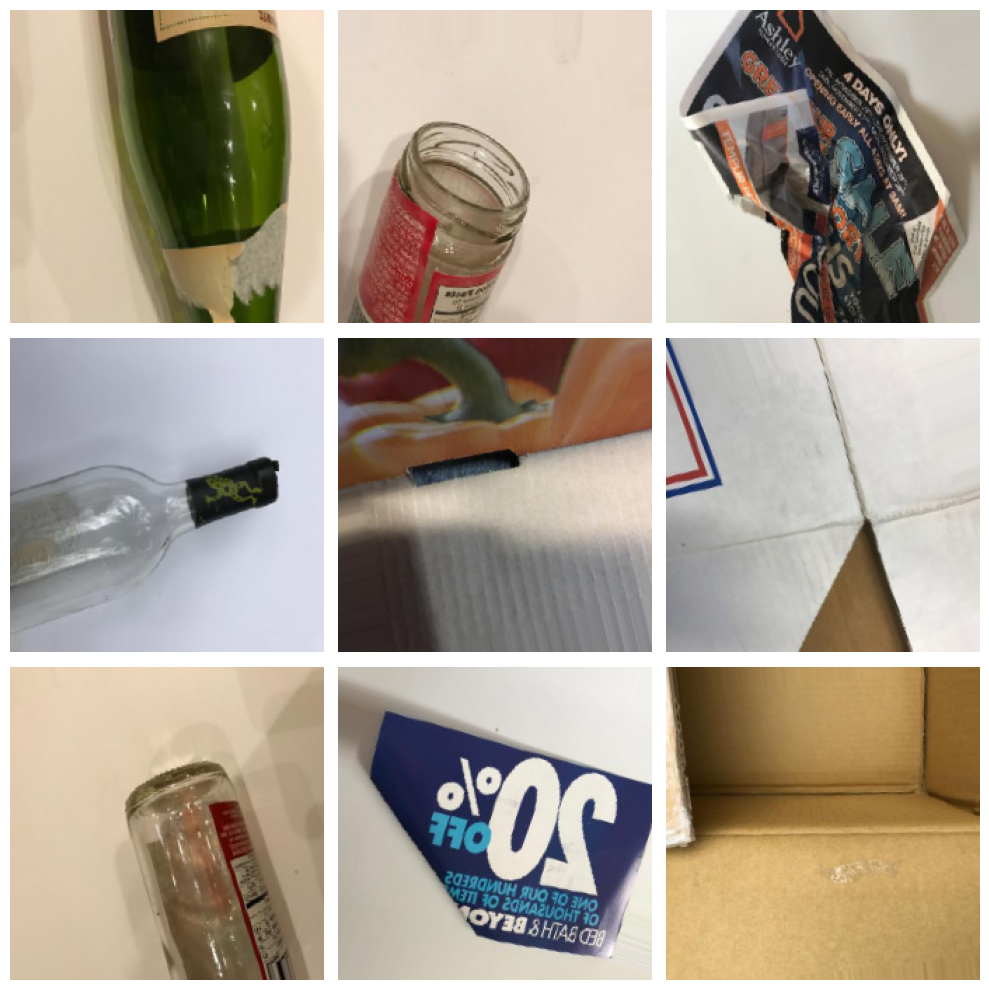

In [ ]:
# Data Augmentation Tanımı (Sadece Eğitim Verisine)
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalizasyon
    rotation_range=20,             # 0-20 derece döndürme
    width_shift_range=0.1,         # Genişlik kaydırması
    height_shift_range=0.1,        # Yükseklik kaydırması
    shear_range=0.15,              # Şekil kaydırma
    zoom_range=0.1,                # Zoom in/out
    horizontal_flip=True,          # Yatay çevirme
    fill_mode='nearest'            # Boş kalan pikselleri doldur
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Validasyonda augmentation yok


# Verileri Generator’a Dönüştür
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),       # Modeline göre değiştir
    batch_size=32,
    class_mode="categorical",     # Eğer etiketler one-hot encode edilecekse
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Opsiyonel) Uygulanan Augmentation'ı Görselleştirme
import matplotlib.pyplot as plt

sample_batch = next(train_generator)
images, labels = sample_batch

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.tight_layout()
plt.show()



Task 3 ve 4

In [ ]:
# 1. NASNetMobile backbone
base_model = NASNetMobile(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 2. Tüm katmanları dondur
for layer in base_model.layers:
    layer.trainable = False

# 3. Sondan 20 katmanı aç
for layer in base_model.layers[-20:]:
    layer.trainable = True

# 4. Üst katmanları oluştur
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# 5. Modeli tanımla
model = Model(inputs=base_model.input, outputs=predictions)

# 6. Compile et
model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_752      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation_752[0… │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_753      │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_755      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_753[0… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_755[0… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_754      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_756      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_754[0

 Total params: 4,405,786 (16.81 MB)

 Trainable params: 306,262 (1.17 MB)

 Non-trainable params: 4,099,524 (15.64 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping: 5 epoch boyunca gelişme yoksa dur
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# En iyi modeli kaydet (val_accuracy’ye göre)
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Val loss iyileşmezse learning rate’i %50 azalt
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop, checkpoint, reduce_lr]


Task 8

In [ ]:
import time

# Zamanı başlat
start_time = time.time()

# Eğitimi başlat
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,                   # İhtiyaca göre arttırılabilir
    callbacks=callbacks,         # Task 7'de tanımlanan callback'ler
    verbose=1
)

# Zamanı bitir
end_time = time.time()

# Süreyi hesapla ve yazdır
print(f"\n✅ Eğitim süresi: {round((end_time - start_time) / 60, 2)} dakika")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2738 - loss: 1.7894
Epoch 1: val_accuracy improved from -inf to 0.66798, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 346s 5s/step - accuracy: 0.2756 - loss: 1.7858 - val_accuracy: 0.6680 - val_loss: 1.0204 - learning_rate: 0.0010
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6060 - loss: 1.0851
Epoch 2: val_accuracy improved from 0.66798 to 0.73518, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.6064 - loss: 1.0839 - val_accuracy: 0.7352 - val_loss: 0.7738 - learning_rate: 0.0010
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6945 - loss: 0.8471
Epoch 3: val_accuracy improved from 0.73518 to 0.74506, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 306s 5s/step - accuracy: 0.6945 - loss: 0.8472 - val_accuracy: 0.7451 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7119 - loss: 0.7735
Epoch 4: val_accuracy improved from 0.74506 to 0.77866, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 309s 5s/step - accuracy: 0.7119 - loss: 0.7737 - val_accuracy: 0.7787 - val_loss: 0.6392 - learning_rate: 0.0010
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7217 - loss: 0.7632
Epoch 5: val_accuracy did not improve from 0.77866
64/64 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.7217 - loss: 0.7628 - val_accuracy: 0.7787 - val_loss: 0.6118 - learning_rate: 0.0010
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7163 - loss: 0.7176
Epoch 6: val_accuracy did not improve from 0.77866
64/64 ━━━━━━━━━━━━━━━━━━━━ 286s 4s/step - accuracy: 0.7167 - loss: 0.7172 - val_accuracy: 0.7787 - val_loss: 0.5913 - learning_rate: 0.0010
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7604 - loss: 0.6654
Epoch 7: val_accuracy improved from 0.77866 to 0.79249, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.7602 - loss: 0.6656 - val_accuracy: 0.7925 - val_loss: 0.5734 - learning_rate: 0.0010
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7549 - loss: 0.6486
Epoch 8: val_accuracy improved from 0.79249 to 0.79644, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.7549 - loss: 0.6485 - val_accuracy: 0.7964 - val_loss: 0.5735 - learning_rate: 0.0010
Epoch 9/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7499 - loss: 0.6464
Epoch 9: val_accuracy improved from 0.79644 to 0.79842, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.7502 - loss: 0.6458 - val_accuracy: 0.7984 - val_loss: 0.5510 - learning_rate: 0.0010
Epoch 10/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7751 - loss: 0.5819
Epoch 10: val_accuracy improved from 0.79842 to 0.80435, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.7750 - loss: 0.5822 - val_accuracy: 0.8043 - val_loss: 0.5516 - learning_rate: 0.0010
Epoch 11/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7642 - loss: 0.6002
Epoch 11: val_accuracy did not improve from 0.80435
64/64 ━━━━━━━━━━━━━━━━━━━━ 351s 5s/step - accuracy: 0.7644 - loss: 0.6001 - val_accuracy: 0.7945 - val_loss: 0.5642 - learning_rate: 0.0010
Epoch 12/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8029 - loss: 0.5665
Epoch 12: val_accuracy did not improve from 0.80435
64/64 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.8028 - loss: 0.5663 - val_accuracy: 0.7905 - val_loss: 0.5494 - learning_rate: 0.0010
Epoch 13/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7905 - loss: 0.5641
Epoch 13: val_accuracy did not improve from 0.80435
64/64 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.7903 - loss: 0.5644 - val_accuracy: 0.7964 - val_loss: 0.5537 - learning_rate: 0.0010
Epoch 14/30
64/64 ━━━━━━━━━━━━━━

64/64 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.8208 - loss: 0.5046 - val_accuracy: 0.8083 - val_loss: 0.5176 - learning_rate: 0.0010
Epoch 17/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8061 - loss: 0.4977
Epoch 17: val_accuracy did not improve from 0.80830
64/64 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.8062 - loss: 0.4977 - val_accuracy: 0.8004 - val_loss: 0.5209 - learning_rate: 0.0010
Epoch 18/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8275 - loss: 0.4862
Epoch 18: val_accuracy improved from 0.80830 to 0.81028, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.8274 - loss: 0.4863 - val_accuracy: 0.8103 - val_loss: 0.5187 - learning_rate: 0.0010
Epoch 19/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8292 - loss: 0.4641
Epoch 19: val_accuracy did not improve from 0.81028
64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.8291 - loss: 0.4644 - val_accuracy: 0.8063 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 20/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8467 - loss: 0.4471
Epoch 20: val_accuracy improved from 0.81028 to 0.81225, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.8466 - loss: 0.4471 - val_accuracy: 0.8123 - val_loss: 0.4983 - learning_rate: 0.0010
Epoch 21/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8209 - loss: 0.4708
Epoch 21: val_accuracy did not improve from 0.81225
64/64 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.8210 - loss: 0.4708 - val_accuracy: 0.8123 - val_loss: 0.4899 - learning_rate: 0.0010
Epoch 22/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8147 - loss: 0.4675
Epoch 22: val_accuracy did not improve from 0.81225
64/64 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.8149 - loss: 0.4674 - val_accuracy: 0.8103 - val_loss: 0.5033 - learning_rate: 0.0010
Epoch 23/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8340 - loss: 0.4364
Epoch 23: val_accuracy improved from 0.81225 to 0.81621, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - accuracy: 0.8341 - loss: 0.4363 - val_accuracy: 0.8162 - val_loss: 0.4836 - learning_rate: 0.0010
Epoch 24/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8399 - loss: 0.4454
Epoch 24: val_accuracy improved from 0.81621 to 0.83004, saving model to best_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.8399 - loss: 0.4453 - val_accuracy: 0.8300 - val_loss: 0.4884 - learning_rate: 0.0010
Epoch 25/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8490 - loss: 0.4314
Epoch 25: val_accuracy did not improve from 0.83004
64/64 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.8490 - loss: 0.4313 - val_accuracy: 0.8202 - val_loss: 0.4903 - learning_rate: 0.0010
Epoch 26/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8437 - loss: 0.4215
Epoch 26: val_accuracy did not improve from 0.83004

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
64/64 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.8437 - loss: 0.4215 - val_accuracy: 0.8142 - val_loss: 0.4867 - learning_rate: 0.0010
Epoch 27/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8486 - loss: 0.4006
Epoch 27: val_accuracy did not improve from 0.83004
64/64 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.8486 - loss: 0.4009 - val_accuracy: 0.82

In [ ]:
import pandas as pd

history_df = pd.DataFrame(history.history)
print(history_df.tail())


    accuracy      loss  val_accuracy  val_loss  learning_rate
25  0.846611  0.422516      0.814229  0.486670         0.0010
26  0.848590  0.415731      0.820158  0.481065         0.0005
27  0.857001  0.400325      0.826087  0.481893         0.0005
28  0.857001  0.406584      0.830040  0.474446         0.0005
29  0.860960  0.385892      0.820158  0.474008         0.0005


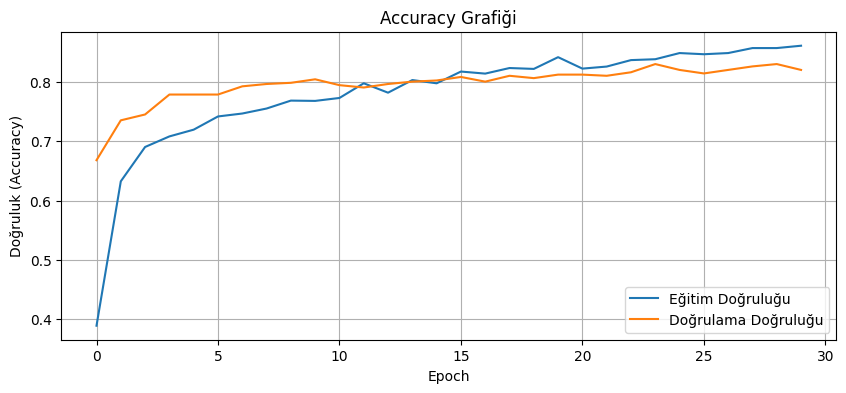

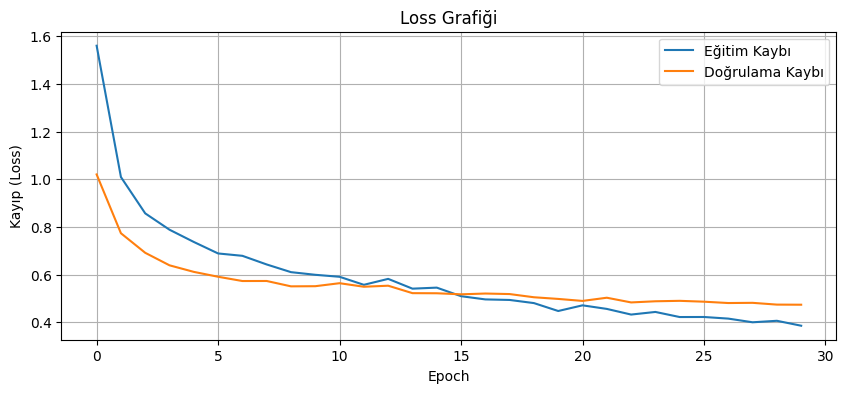

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Accuracy Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Loss Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
best_epoch = history_df['val_accuracy'].idxmax()
best_val_acc = history_df['val_accuracy'].max()
print(f"✅ En iyi epoch: {best_epoch + 1} (val_accuracy: {best_val_acc:.4f})")


✅ En iyi epoch: 24 (val_accuracy: 0.8300)
